In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cmocean
import zarr 
import cartopy.crs as ccrs
import mplsettings
from dask.diagnostics import ProgressBar
import momlevel

In [2]:
dirstix = "/net2/rnd/dev/stixfonts/fonts/static_ttf"
import matplotlib.font_manager as font_manager
for font in font_manager.findSystemFonts(dirstix):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'STIX Two Text'

In [3]:
dset_path = '/net2/jet/sst/GLORYS12V1_1993to2020_tos_daily.xy'
vars_ds = xr.open_zarr(dset_path,use_cftime=True)

In [4]:
# read in zarr store files for dailies 
tos = vars_ds['tos']

In [5]:
# compute the anomalies relative to this daily mean climatology
tos_daily_clim = tos.groupby('time.dayofyear').mean('time')
tos_daily_anom = tos.groupby('time.dayofyear') - tos_daily_clim  
tos_daily_std  = tos_daily_anom.std(dim='time')

In [7]:
geolon, geolat = momlevel.util.tile_nominal_coords(tos_daily_std.longitude,tos_daily_std.latitude)
tos_daily_std  = tos_daily_std.assign_coords({'geolon': geolon, 'geolat': geolat})

/nbhome/ogrp/python/envs/py311_20241018/lib/python3.11/site-packages/momlevel/util.py:520: UserWarning: Constructing coordinates from 1-D vectors. Make sure this is the intended behavior. Do not use `xh`/`yh` when `geolon`/`geolat` are available
  warnings.warn(


In [36]:
with ProgressBar():
    tos_daily_std.load()

[####################################### ] | 99% Completed | 115m 14s

/nbhome/ogrp/python/envs/py311_20241018/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 115m 16s


In [90]:
tos_daily_std.to_netcdf('/work/jet/GLORYS12V1_tos_daily_std.nc',format='NETCDF4')

In [6]:
tos_daily_std = xr.open_dataset('/work/jet/GLORYS12V1_tos_daily_std.nc').tos

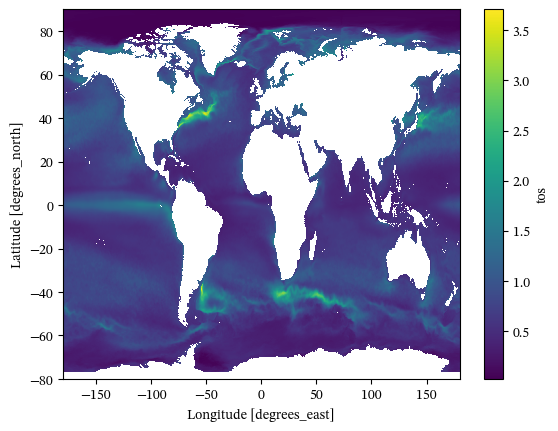

In [8]:
tos_daily_std.plot()

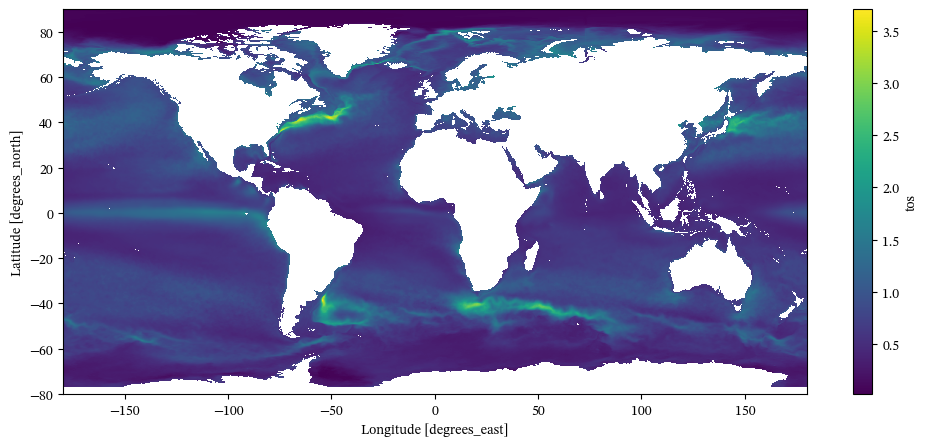

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
p = tos_daily_std.plot(ax=ax, x="longitude", y="latitude")

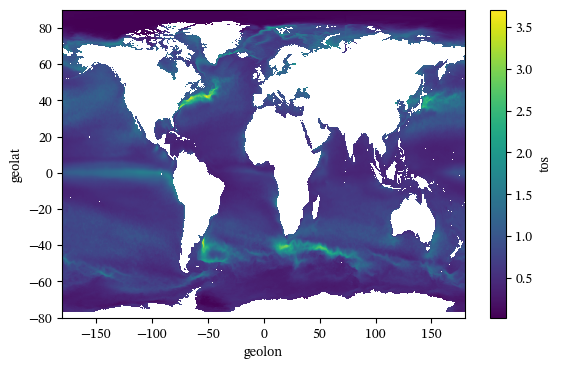

In [10]:
# Create the plot using 2D coordinates
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 4.0))
p = tos_daily_std.plot(ax=axis, x="geolon", y="geolat")
plt.show()

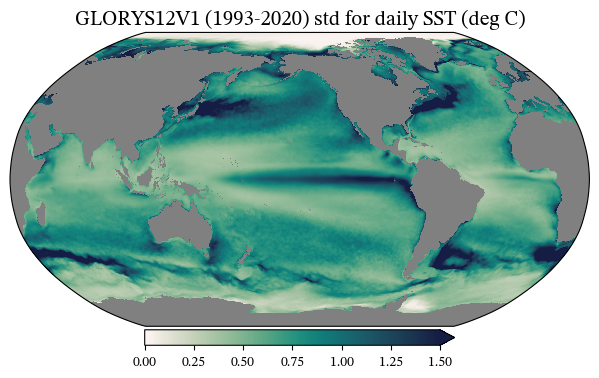

In [92]:
field = tos_daily_std
vmin=0
vmax=1.5

fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(6.5,4.0),
             subplot_kw={'projection': ccrs.Robinson(central_longitude=-150)})

p=field.plot(ax=axis, x="geolon", y="geolat",vmin=vmin, vmax=vmax,
             transform=ccrs.PlateCarree(), cmap=cmocean.cm.tempo,
                           add_colorbar=False
            )
#axs.gridlines()
plt.gca().set_facecolor('gray')
plt.tick_params(labelsize=12) 
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('GLORYS12V1 (1993-2020) std for daily SST (deg C)', fontsize=15)
cbar = plt.colorbar(p,pad=0.01,spacing='uniform', 
                    extend='max',shrink=0.5,orientation='horizontal')
plt.tight_layout()
plt.show()
fig.savefig('GLORYS12V1_tos_daily_std.jpg', bbox_inches='tight', dpi=400, format='jpeg')